### Imports & Settings

In [1]:
import torch

from torch import nn, optim

from torch.utils.data import DataLoader, TensorDataset

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

import cv2

import copy
import time

In [2]:
torch.manual_seed(123)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(torch.__version__)
print(device)

2.2.2+cu121
cpu


### Modules

In [3]:
class SineActivation(nn.Module):
    def __init__(self):
        super(SineActivation, self).__init__()
        
    def forward(self, x):
        return torch.sin(x)

In [4]:
class FullyConnected(nn.Module):
    '''
    Builds a fully connected neural network from a list of layer sizes and an optional activation function.
    
    Args:
        fc_sizes (list): Sizes of each layer in the network.
        activation (nn.Module): Activation function applied between layers, defaults to SineActivation.
    '''
    def __init__(self, fc_sizes: list, activation=SineActivation):
        super(FullyConnected, self).__init__()
        
        layers = []
        for size_in, size_out in zip(fc_sizes[:-1], fc_sizes[1:-1]):
            layers.append(nn.Linear(size_in, size_out))
            layers.append(activation())
        
        layers.append(nn.Linear(fc_sizes[-2], fc_sizes[-1]))
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

### Utils

In [5]:
def timer(func):
    '''
    Decorator to measure and print the execution time of the decorated function.

    Args:
        func (callable): Function to measure.

    Returns:
        callable: Wrapped function with timing.
    '''
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f'Executed in {end_time - start_time} seconds.')
        return result
    return wrapper

In [6]:
def get_normal_field(f):
    def normal_field(x):
        '''
        Compute the normal to the implicit surface represented by a predetermined neural signed distance field.

        Args:
            x (torch.Tensor): A tensor representing a vector in the input space where the normal will be computed.

        Returns:
            torch.Tensor: The normal to the zero-level set of the neural field at point `x`, normalized to unit length.
        '''
        x = x.requires_grad_(True) 

        f_value = f(x)
        grad = torch.autograd.grad(
            outputs=f_value, 
            inputs=x, 
            grad_outputs=torch.ones_like(f_value),
            create_graph=True)[0]
        normal = grad / torch.sqrt(torch.sum(grad ** 2))

        return normal
    return normal_field


In [7]:
def get_uniform_field(f):
    return uniform_field

def uniform_field(x):
    return torch.ones_like(x)

In [8]:
def get_sphere_sdf(r):
    def sphere_sdf(x):
        '''
        Computes the signed distance from the point `x` to a sphere centered at the origin with radius `r`.

        Args:
            x (torch.Tensor): A tensor representing a point in space.

        Returns:
            float: The signed distance from the point `x` to the surface of the sphere.
        '''
        return torch.sum(x ** 2, dim=-1) - r ** 2
    return sphere_sdf

In [9]:
def create_grid(res=100):
    '''
    Returns a grid of 2D points and the corresponding x, y meshgrid arrays.

    Args:
        res (int): The resolution of the grid, default is 100.

    Returns:
        grid (torch.Tensor): Flattened grid coordinates.
        x (torch.Tensor): X coordinates of the meshgrid.
        y (torch.Tensor): Y coordinates of the meshgrid.
    '''
    p = torch.linspace(-1, 1, res)
    x, y = torch.meshgrid(p, p, indexing='xy')
    grid = torch.stack((x.flatten(), y.flatten()), dim=-1).to(device)
    return grid, x, y

In [10]:
def plot_sdf(net, res=100, contour_lines=15, colormap='RdBu'):
    '''
    Visualizes the SDF generated by a neural network over a fixed range from -1 to 1 for both x and y axes.

    Args:
        net (torch.nn.Module): Neural network model to generate SDF values.
        res (int): Number of points along each axis (res x res grid).
        contour_lines (int): Number of contour lines in the plot.
        colormap (str): Colormap used for visualization.
    '''
    grid, x, y = create_grid(res)

    with torch.no_grad():
        z = net(grid).view(res, res).cpu()

    fig, ax = plt.subplots()

    max_abs_value = max(abs(z.min()), abs(z.max()))
    contour_levels = torch.linspace(-max_abs_value, max_abs_value, contour_lines)
    
    c = ax.contourf(
        x.numpy(), y.numpy(), z.numpy(), 
        levels=contour_levels.numpy(), 
        cmap=colormap, 
        origin='lower')
    plt.colorbar(c, ax=ax)
    
    ax.contour(x.numpy(), y.numpy(), z.numpy(), levels=[0], colors='black', linewidths=2)
    ax.set_aspect('equal', 'box')
    
    plt.show()

In [11]:
def generate_sdf_video(net, total_time_steps=100, res=200, fps=10):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
    out = cv2.VideoWriter('sdf_evolution.mp4', fourcc, fps, (2*res, 2*res))

    grid, x, y = create_grid(res)

    dpi = 100  
    figsize = (2*res / dpi, 2*res / dpi)  

    for t in torch.linspace(0, 1, total_time_steps):
        with torch.no_grad():
            grid_t = torch.cat((grid, t.repeat(grid.shape[0], 1)), dim=1)
            z = net(grid_t).view(res, res).cpu()

        fig, ax = plt.subplots(figsize=figsize)
        max_abs_value = max(abs(z.min()), abs(z.max()))
        contour_levels = torch.linspace(-max_abs_value, max_abs_value, 15)

        ax.contourf(x.numpy(), y.numpy(), z.numpy(), levels=contour_levels.numpy(), cmap='RdBu')
        ax.contour(x.numpy(), y.numpy(), z.numpy(), levels=[0], colors='black', linewidths=2)
        ax.set_aspect('equal', 'box')
        ax.axis('off')  

        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        out.write(img)

### 1. Training a test SDF

In [12]:
layer_sizes = [2, 128, 128, 128, 1]
net = FullyConnected(layer_sizes).to(device)

learning_rate = 1e-5
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [13]:
n = 25
grid, _, _ = create_grid(n)

In [14]:
radius = .5
sdf_values = get_sphere_sdf(radius)(grid)

X = grid.to(device)
Y = sdf_values.to(device)
dataset = TensorDataset(X, Y)

batch_size = 1
dataloader = DataLoader(dataset, batch_size)

In [15]:
num_epochs = 100
print_every = 5

In [16]:
@timer
def train_sdf():
    for epoch in range(1, num_epochs+1):
        for batch_x, batch_y in dataloader:
            optimizer.zero_grad()
            preds = net(batch_x).flatten()
            loss = nn.MSELoss()(preds, batch_y)
            loss.backward()
            optimizer.step()
        
        if epoch % print_every == 0:
            net.eval()
            preds = net(X).flatten()
            loss = nn.MSELoss()(preds, Y)
            print(f'[{epoch}/{num_epochs}] Loss = {loss}')
            net.train()

train_sdf()

KeyboardInterrupt: 

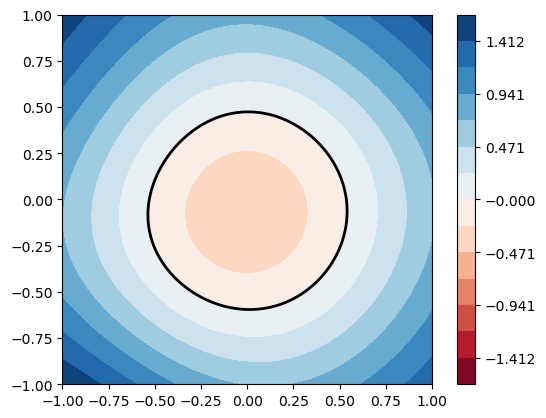

In [ ]:
plot_sdf(net)

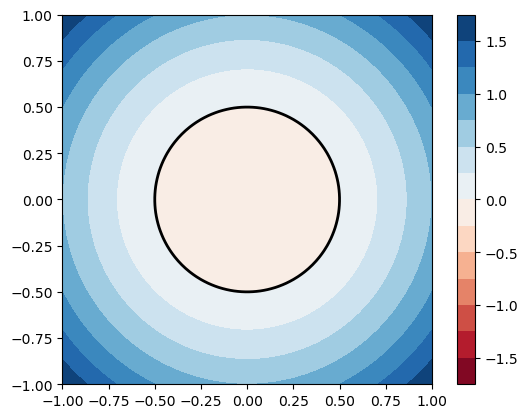

In [ ]:
plot_sdf(get_sphere_sdf(radius))

### 2. Solving the initial value problem

In [ ]:
def get_pde_loss(net, V, input: dict, speed=1):
    phi_xt = net(input['xyt'])

    grad_phi = torch.autograd.grad(
        outputs=phi_xt, 
        inputs= input['xyt'],
        grad_outputs=torch.ones_like(phi_xt),
        create_graph=True
    )[0]

    dx_phi = grad_phi[0:2]
    dt_phi = grad_phi[2]

    Vx = V(input['xy'])
    n = input['xyt'].size(0) // input['xy'].size(0) # n = number of time steps
    prod = torch.einsum('ij, ij -> i', speed * Vx.repeat(n, 1), dx_phi).view(-1,1)

    return torch.mean((dt_phi + prod) ** 2)

In [ ]:
def get_ic_loss(net, f, input: dict):
    return torch.mean((net(input['xyt0']) - f(input['xy'])) ** 2)

In [ ]:
layer_sizes = [3, 128, 128, 128, 64, 64, 1]
pinn = FullyConnected(layer_sizes).to(device)

In [ ]:
learning_rate = 1e-4
optimizer = optim.Adam(pinn.parameters(), lr=learning_rate)

In [ ]:
n = 25
x0, x1, y0, y1 = -1, 1, -1, 1
t0, t1 = 0, 1

x = torch.linspace(x0, x1, n)
y = torch.linspace(y0, y1, n)
t = torch.linspace(t0, t1, n)

X, Y, T = torch.meshgrid(x, y, t, indexing='ij')
XT = torch.stack((X.flatten(), Y.flatten(), T.flatten()), dim=1).requires_grad_(True)

_X, _Y = torch.meshgrid(x, y, indexing='ij')
grid = torch.stack((_X.flatten(), _Y.flatten()), dim=1).requires_grad_(True)

T0 = torch.zeros_like(_X) 
XT0 = torch.stack((_X.flatten(), _Y.flatten(), T0.flatten()), dim=1).requires_grad_(True)

input_pde = dict(xyt=XT, xy=grid)
input_ic = dict(xyt0=XT0, xy=grid)

In [ ]:
num_epochs = 2500
print_every = 5

In [ ]:
@timer
def run_pinn_training():
    for epoch in range(1, num_epochs+1):
        optimizer.zero_grad()
        pde_loss = get_pde_loss(pinn, get_normal_field(net), input_pde) 
        ic_loss = get_ic_loss(pinn, net, input_ic)
        loss = 0.01 * pde_loss + ic_loss
        loss.backward()
        optimizer.step()

        if epoch % print_every == 0:
            print(f'Epoch [{epoch}/{num_epochs}] Loss = {loss.item()}')
run_pinn_training()

Epoch [5/2500] Loss = 0.34909841418266296
Epoch [10/2500] Loss = 0.3059515655040741
Epoch [15/2500] Loss = 0.27144408226013184
Epoch [20/2500] Loss = 0.24668589234352112
Epoch [25/2500] Loss = 0.23343943059444427
Epoch [30/2500] Loss = 0.230379119515419
Epoch [35/2500] Loss = 0.2305847555398941
Epoch [40/2500] Loss = 0.22840352356433868
Epoch [45/2500] Loss = 0.22495484352111816
Epoch [50/2500] Loss = 0.22250032424926758
Epoch [55/2500] Loss = 0.22097879648208618
Epoch [60/2500] Loss = 0.21951450407505035
Epoch [65/2500] Loss = 0.21783219277858734
Epoch [70/2500] Loss = 0.21615804731845856
Epoch [75/2500] Loss = 0.214630588889122
Epoch [80/2500] Loss = 0.2131464034318924
Epoch [85/2500] Loss = 0.21163301169872284
Epoch [90/2500] Loss = 0.21014679968357086
Epoch [95/2500] Loss = 0.20871789753437042
Epoch [100/2500] Loss = 0.2073294222354889
Epoch [105/2500] Loss = 0.2060052454471588
Epoch [110/2500] Loss = 0.20479024946689606
Epoch [115/2500] Loss = 0.2037137746810913
Epoch [120/2500] L

In [ ]:
generate_sdf_video(pinn)

/var/tmp/ipykernel_320507/2057848402.py:35: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
